## Advanced Lane Finding Project

### 04 Pipeline

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard image.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import cv2
import glob
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

## Load and show test images

In [2]:
# Load test images.
test_images = list(map(lambda filename: (filename, cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)), glob.glob('test_images/*.jpg')))

In [3]:
# Display images on a [cols, rows] subplot grid
def show_images(images, cols = 4, rows = 2, figsize=(25,6), cmap = None):
    f, axes = plt.subplots(rows, cols, figsize=figsize)
    f.tight_layout()
    plt.subplots_adjust(left=0., right=1, top=1.4, bottom=0.)
    
    indexes = range(cols * rows)
    
    for ax, index in zip(axes.flat, indexes):
        if index < len(images):
            filename, image = images[index]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap=cmap)
            ax.set_title(filename, fontsize=25)

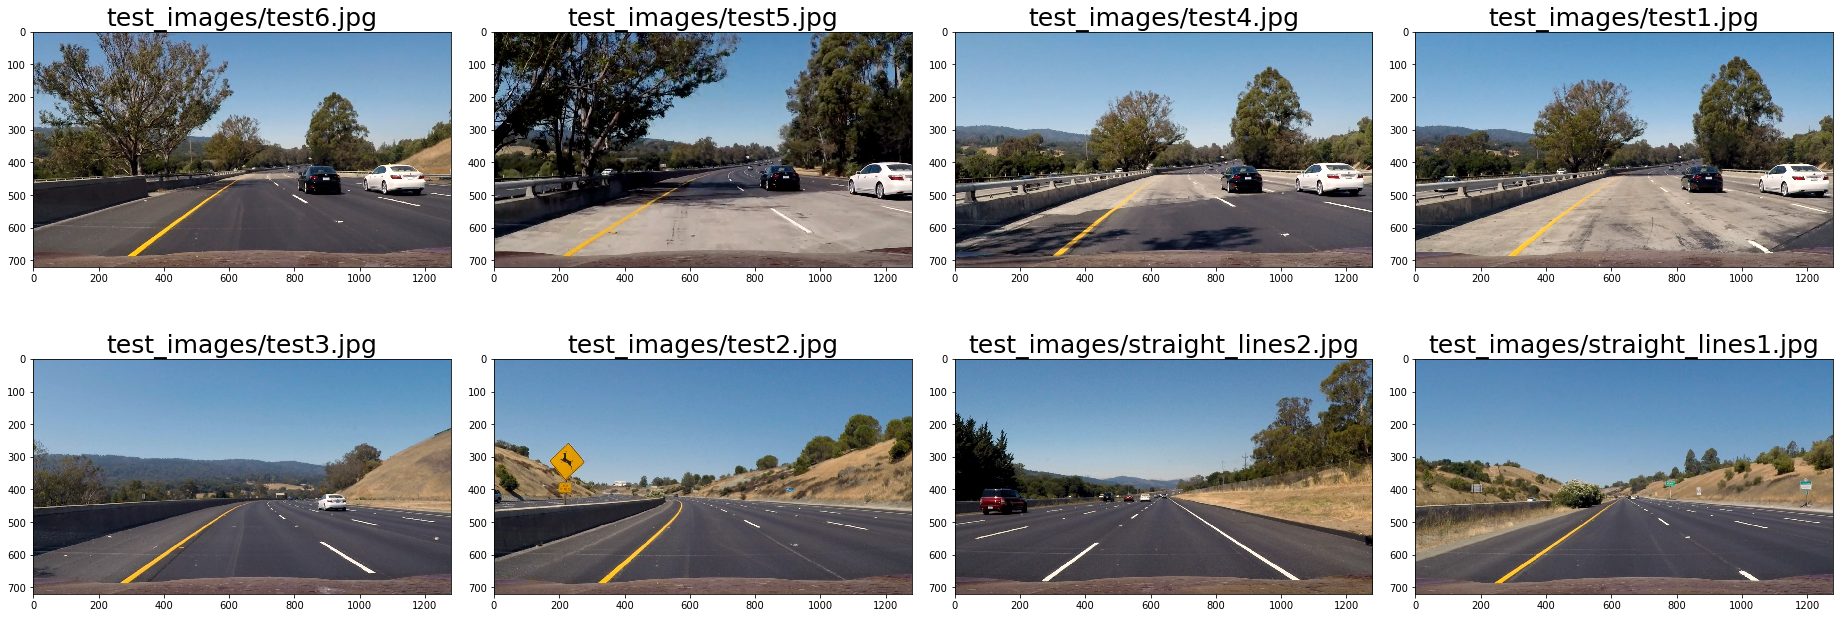

In [4]:
# Show test images
show_images(test_images, 4, 2, (25,6))

## Apply a distortion correction to raw images

In [5]:
# Loading camera calibration (calculated in 01_Camera_Calibartion.ipynb)
camera_cal = pickle.load(open('camera_cal/camera_calibration.p', 'rb'))
mtx, dist = map(camera_cal.get, ('mtx', 'dist'))

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

## Use color transforms, gradients, etc., to create a thresholded binary image

In [6]:
# Function that combined S channel and Sobel x on a undistorted image
def undistort_binary(img, sobel_kernel=3, x_thresh=(20, 100), s_thresh=(170, 255)):
    # Undistort image
    img = undistort(img)
    
    # Convert to HLS color space and separate the S channelon a undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image for sobel gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= x_thresh[0]) & (scaled_sobel <= x_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Combine the two binary thresholds
    combined_binary_output = np.zeros_like(sxbinary)
    combined_binary_output[(s_binary == 1) | (sxbinary == 1)] = 1
    
    # Return the binary image
    return combined_binary_output

In [7]:
test_images_undistort_binary = list(map(lambda img: (img[0], undistort_binary(img[1])), test_images))

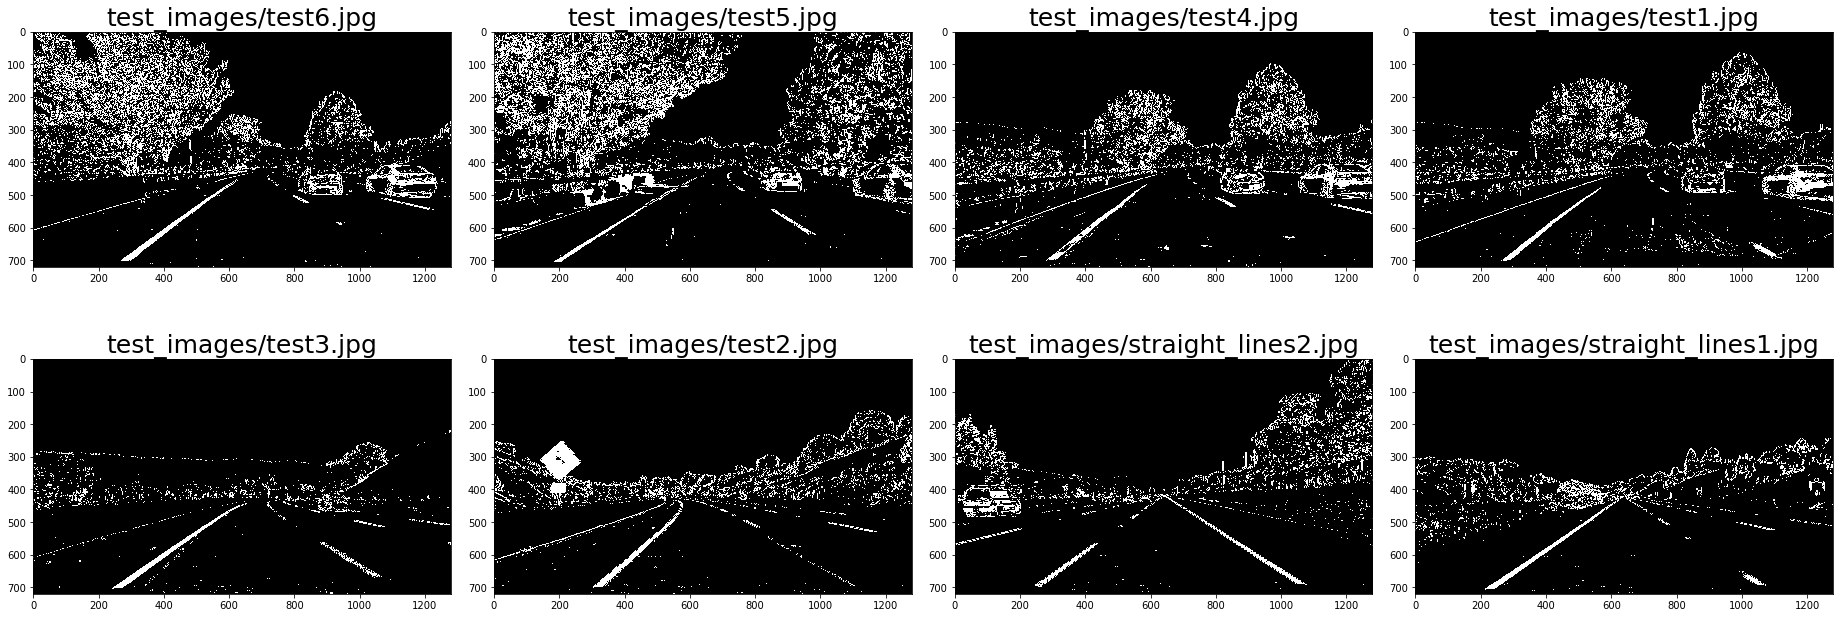

In [8]:
show_images(test_images_undistort_binary, 4, 2, (25,6), cmap='gray')

## Apply a perspective transform to rectify binary image ("birds-eye view")

In [9]:
def draw_src_points(img, src):
    img_copy = img.copy()
    color = [255, 0, 0]
    w = 3
    cv2.line(img_copy, (src[1][0], src[1][1]), (src[0][0], src[0][1]), color, w)
    cv2.line(img_copy, (src[0][0], src[0][1]), (src[3][0], src[3][1]), color, w)
    cv2.line(img_copy, (src[3][0], src[3][1]), (src[2][0], src[2][1]), color, w)
    cv2.line(img_copy, (src[2][0], src[2][1]), (src[1][0], src[1][1]), color, w)
    
    return img_copy

In [10]:
def binary_warped_transform(img):  
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32(
        [[img_size[0] / 2 - 65, img_size[1] / 2 + 100],
        [img_size[0] / 6 - 25, img_size[1]],
        [img_size[0] * 5 / 6 + 60, img_size[1]],
        [img_size[0] / 2 + 65, img_size[1] / 2 + 100]])
    
    offset = 200
    dst = np.float32(
        [[offset, 0],
        [offset, img_size[1]], 
        [img_size[0]-offset, img_size[1]],
        [img_size[0]-offset, 0]])    
    
    # Compute and apply perpective transform
    M = cv2.getPerspectiveTransform(src, dst)
    binary_warped = cv2.warpPerspective(undistort_binary(img), M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return binary_warped

In [11]:
test_images_binary_warped = list(map(lambda img: (img[0], binary_warped_transform(img[1])), test_images))

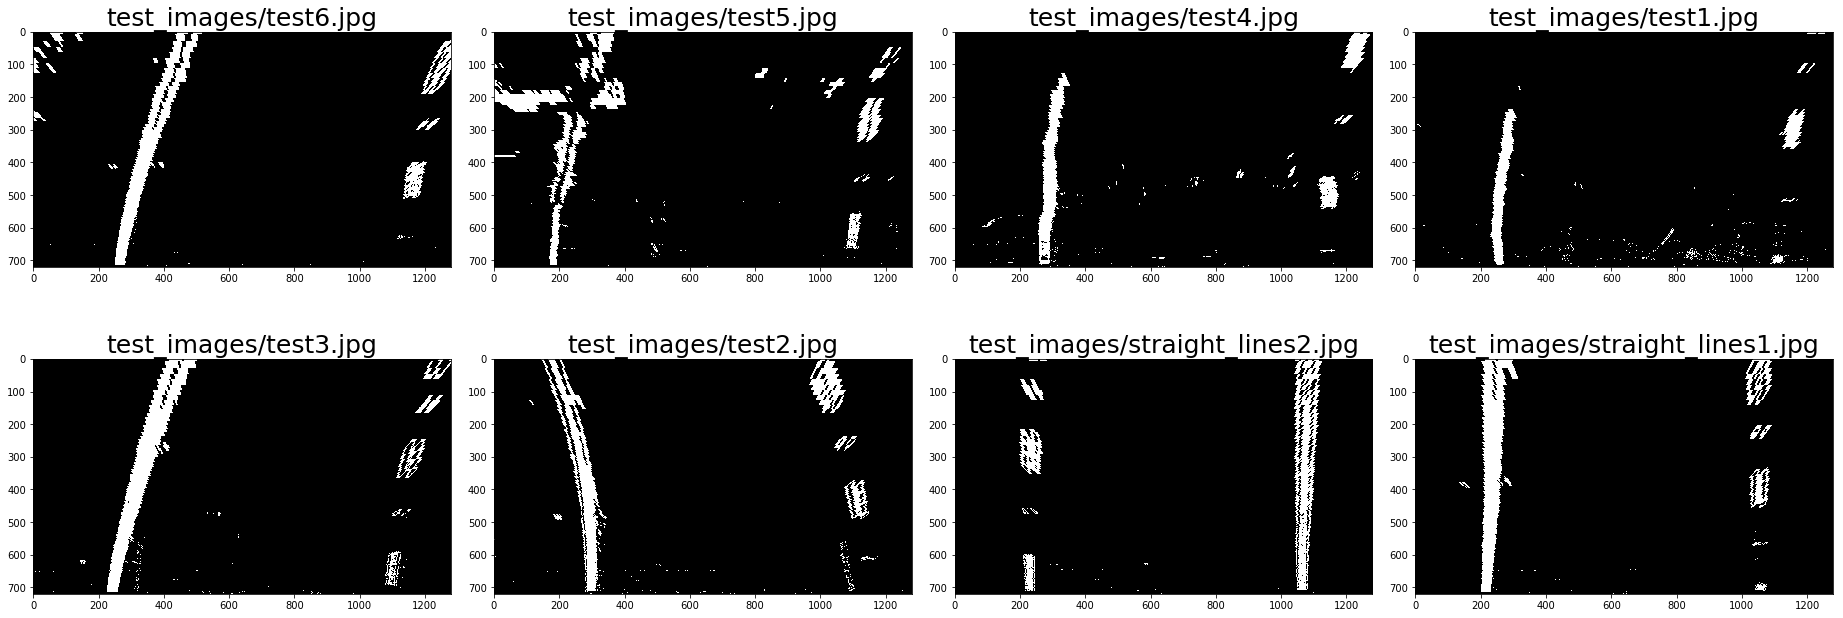

In [12]:
show_images(test_images_binary_warped, 4, 2, (25,6), cmap='gray')

## Detect lane pixels and fit to find the lane boundary

In [13]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [14]:
# Function that find the polynomial representation of the lines in an image
def detect_lane_lines(image): 
    # Make a binary and wraped image
    binary_warped = binary_warped_transform(image)
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)

In [15]:
# Function that visualize the windows and fitted lines
def visualize_lane_lines(image, ax):
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = detect_lane_lines(image)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ax.imshow(out_img)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    # ax.xlim(0, 1280)
    # ax.ylim(720, 0)
    
    return ( left_fit, right_fit, left_fit_m, right_fit_m )

In [16]:
# Display lane lines in an image on a subplot grid
def show_lane_lines(images, cols = 4, rows = 2, figsize=(25,6)):
    f, axes = plt.subplots(rows, cols, figsize=figsize)
    f.tight_layout()
    plt.subplots_adjust(left=0., right=1, top=1.4, bottom=0.)
    
    indexes = range(cols * rows)
    images_polynomial = []
    
    for ax, index in zip(axes.flat, indexes):
        if index < len(images):
            filename, image = images[index]
            left_fit, right_fit, left_fit_m, right_fit_m = visualize_lane_lines(image, ax)
            ax.set_title(filename, fontsize=25)
            images_polynomial.append( ( filename, left_fit, right_fit, left_fit_m, right_fit_m ) )
    
    return images_polynomial

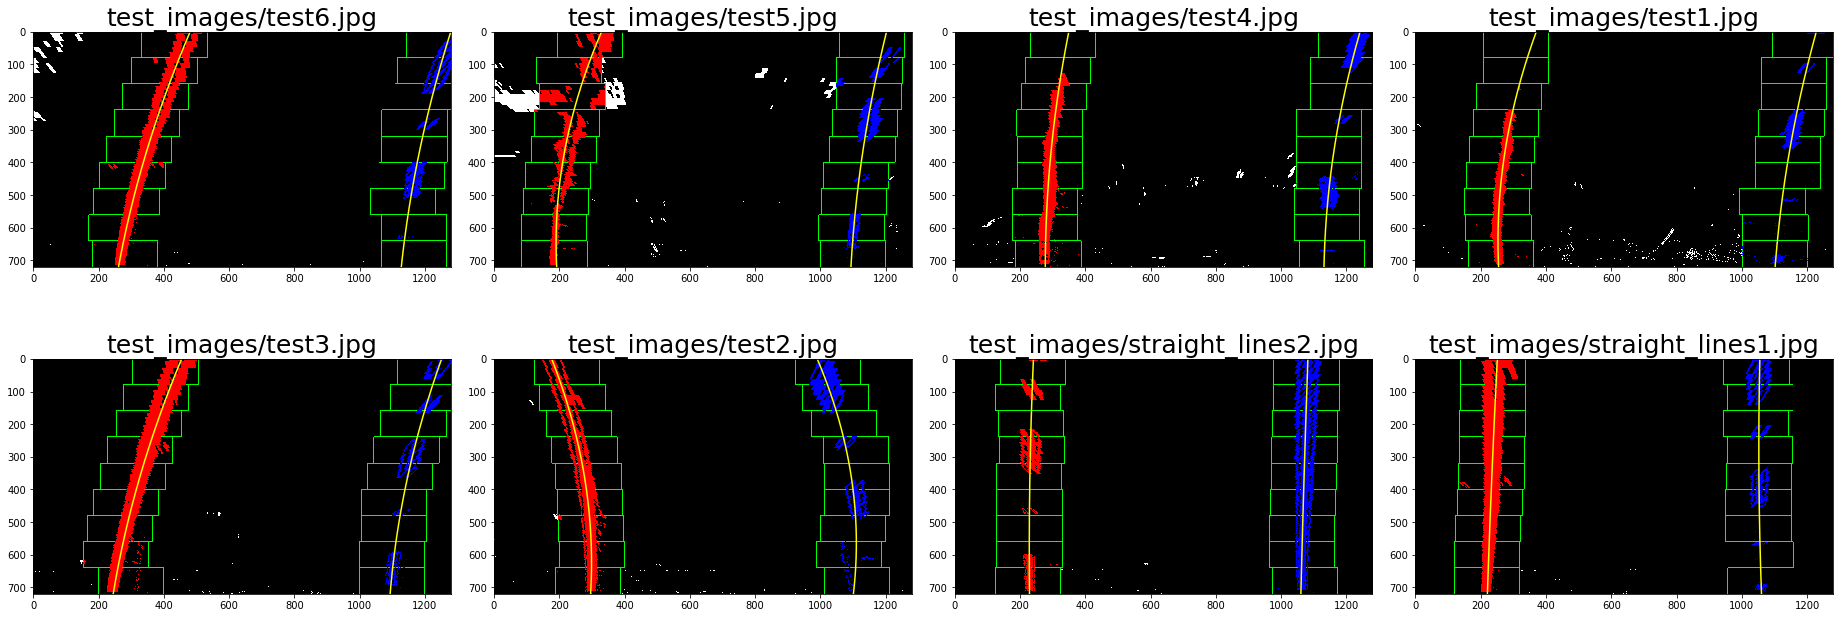

In [17]:
test_images_polynomial = show_lane_lines(test_images, 4, 2, (25, 6))

## Determine the curvature of the lane and vehicle position with respect to center.

In [18]:
# Returns the curvature of the polynomial `fit` on the y range `yRange`.
def calculate_curvature(y_range, fit):
    return ((1 + ((fit[0]**2)*y_range*ym_per_pix + fit[1])**2)**1.5) / np.absolute(2*fit[0])

In [19]:
def calculate_position_center(x_range, y_range, left_fit_m, right_fit_m):
    x_max = x_range * xm_per_pix
    y_max = y_range * ym_per_pix
    
    vehicle_center = x_max / 2
    line_left = left_fit_m[0]*y_max**2 + left_fit_m[1]*y_max + left_fit_m[2]
    line_right = right_fit_m[0]*y_max**2 + right_fit_m[1]*y_max + right_fit_m[2]
    line_middle = line_left + (line_right - line_left)/2
    
    # right if vehicle_diff > 0, left if vehicle_diff <= 0
    vehicle_diff = line_middle - vehicle_center
    
    if vehicle_diff > 0:
        message = '{:.2f} m right'.format(vehicle_diff)
    else:
        message = '{:.2f} m left'.format(-vehicle_diff)
        
    return vehicle_diff

In [20]:
for image_polynomial in test_images_polynomial:
    filename, left_fit, right_fit, left_fit_m, right_fit_m = image_polynomial
    x_range = 1280
    y_range = 720 #719
    left_curvature = calculate_curvature(y_range, left_fit_m) 
    right_curvature = calculate_curvature(y_range, right_fit_m) 
    position_center = calculate_position_center(x_range, y_range, left_fit_m, right_fit_m)
    print('Image : {}, Left: {:.2f} m, Right: {:.2f} m, Center: {:.2f} m'.format(filename, left_curvature, right_curvature, position_center))

Image : test_images/test6.jpg, Left: 983.40 m, Right: 1138.81 m, Center: 0.29 m
Image : test_images/test5.jpg, Left: 494.47 m, Right: 1248.57 m, Center: 0.01 m
Image : test_images/test4.jpg, Left: 1204.39 m, Right: 887.73 m, Center: 0.34 m
Image : test_images/test1.jpg, Left: 576.38 m, Right: 1184.14 m, Center: 0.20 m
Image : test_images/test3.jpg, Left: 941.37 m, Right: 858.34 m, Center: 0.15 m
Image : test_images/test2.jpg, Left: 525.99 m, Right: 438.87 m, Center: 0.31 m
Image : test_images/straight_lines2.jpg, Left: 4386.06 m, Right: 22413.50 m, Center: 0.03 m
Image : test_images/straight_lines1.jpg, Left: 12797.69 m, Right: 4031.75 m, Center: 0.00 m


## Warp the detected lane boundaries back onto the original image.

In [21]:
def binary_warped_inverse(img):  
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32(
        [[img_size[0] / 2 - 65, img_size[1] / 2 + 100],
        [img_size[0] / 6 - 25, img_size[1]],
        [img_size[0] * 5 / 6 + 60, img_size[1]],
        [img_size[0] / 2 + 65, img_size[1] / 2 + 100]])
    
    offset = 200
    dst = np.float32(
        [[offset, 0],
        [offset, img_size[1]], 
        [img_size[0]-offset, img_size[1]],
        [img_size[0]-offset, 0]])    
    
    # Compute and apply inverse perpective transform
    M = cv2.getPerspectiveTransform(dst, src)
    binary_warped_inverse = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return binary_warped_inverse

In [22]:
# Function that draw the lane area on the image, optional with display informatino about curvature and center position
def draw_lane_area(img, display_info='no'):
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = detect_lane_lines(img)
        
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp back to original image space using inverse perspective matrix
    warped = binary_warped_inverse(color_warp)
    
    image_output = cv2.addWeighted(img, 1, warped, 0.3, 0)
    
    if display_info == 'yes':
        x_range = img.shape[1]
        y_range = img.shape[0] 
        fontScale=2
        
        left_curvature = calculate_curvature(y_range, left_fit_m) / 1000
        right_curvature = calculate_curvature(y_range, right_fit_m) / 1000
        position_center = calculate_position_center(x_range, y_range, left_fit_m, right_fit_m)
        
        # Draw display info
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontColor = (255, 255, 255)
        cv2.putText(image_output, 'Left curvature: {:.2f} m'.format(left_curvature), (50, 50), font, fontScale, fontColor, 2)
        cv2.putText(image_output, 'Right curvature: {:.2f} m'.format(right_curvature), (50, 120), font, fontScale, fontColor, 2)
        cv2.putText(image_output, 'Vehicle center position: {:.2f}'.format(position_center), (50, 190), font, fontScale, fontColor, 2)
    
    return image_output

In [23]:
test_images_lane_area = list(map(lambda img: (img[0], draw_lane_area(img[1])), test_images))

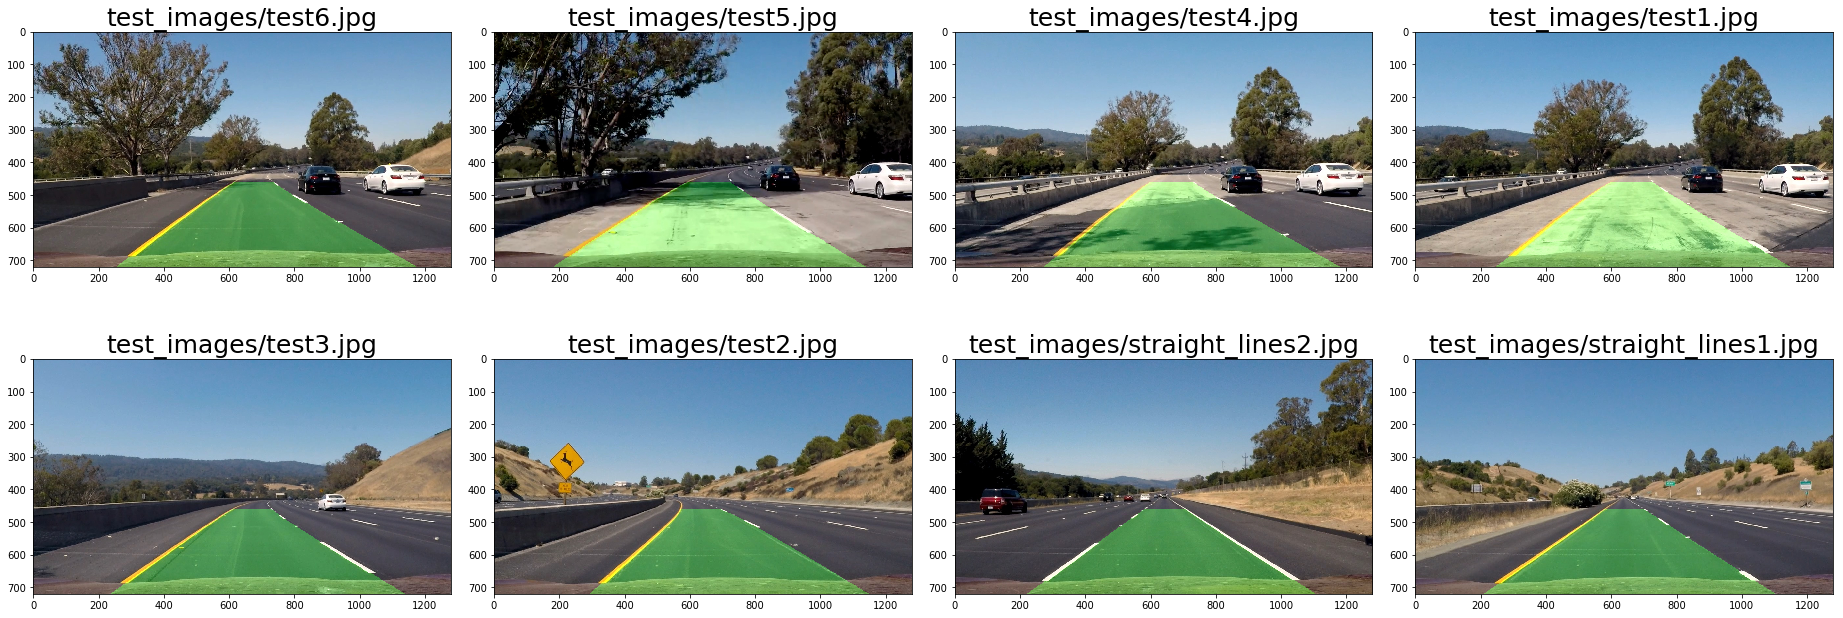

In [24]:
show_images(test_images_lane_area, 4, 2, (25,6))

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [25]:
test_images_lane_area_info = list(map(lambda img: (img[0], draw_lane_area(img[1], display_info='yes')), test_images))

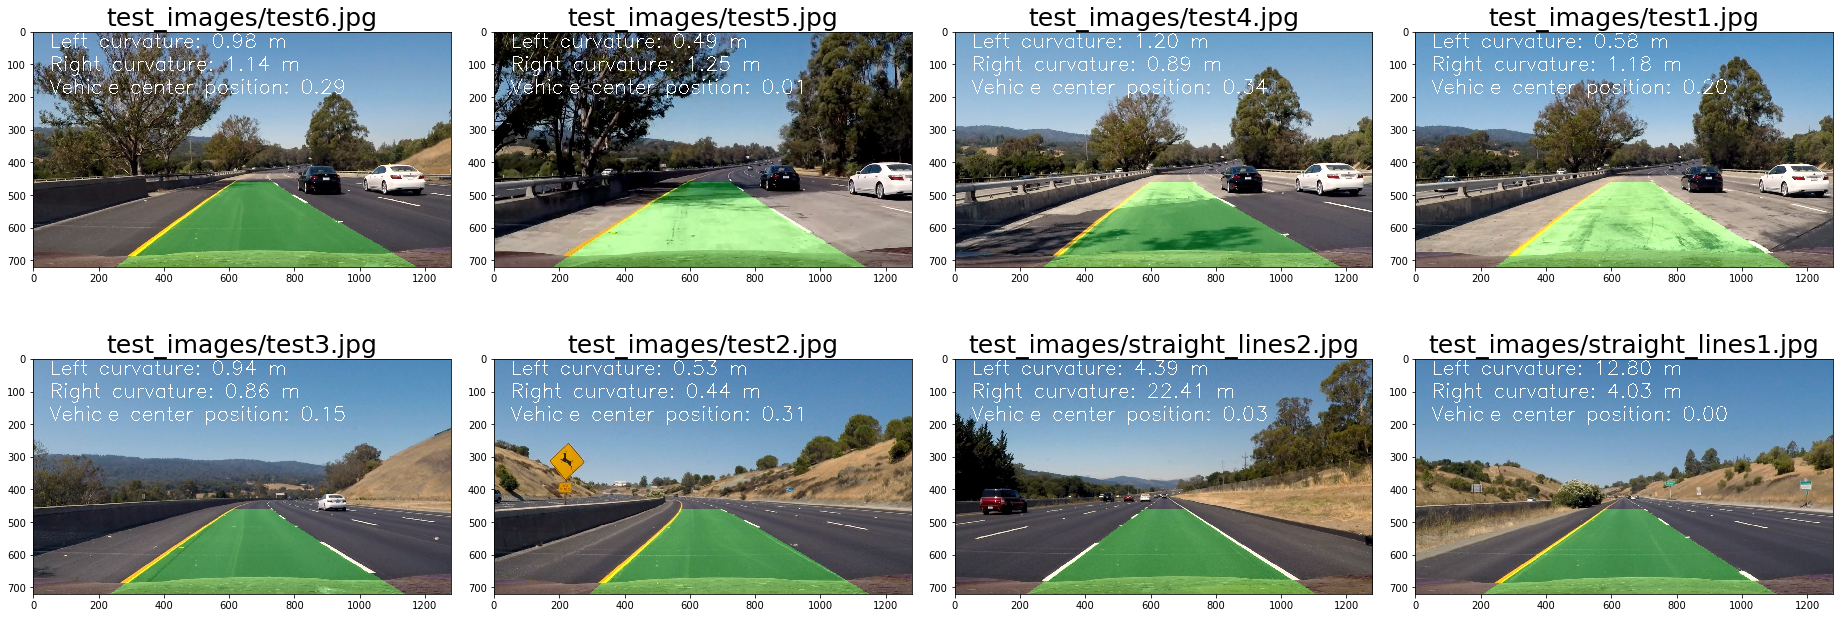

In [26]:
show_images(test_images_lane_area_info, 4, 2, (25,6))